In [85]:
import numpy as np
import torch
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [86]:
def model(X, Theta):
    return torch.matmul(X, Theta)

def loss_fn(X_predict, y):
    return torch.mean((X_predict - y) ** 2)

def get_X_split_indices(X, ratio):
    n_samples = X.shape[0]
    n_test = int(ratio * n_samples)
    shuffled_indices = torch.randperm(n_samples)
    train_indices = shuffled_indices[:-n_test]
    test_indices = shuffled_indices[-n_test:]
    
    return train_indices, test_indices

def training_loop(optimizer, X_train, y_train, X_val, y_val, Theta, n_epochs):
    train_predict = []
    val_predict = []
    
    for epoch in range(1, n_epochs + 1):
        X_train_predict = model(X_train, Theta)
        train_loss = loss_fn(X_train_predict, y_train)
        
        with torch.no_grad():
            X_val_predict = model(X_val, Theta)
            val_loss = loss_fn(X_val_predict, y_val)
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch > 500:
            train_predict.append(train_loss)
            val_predict.append(val_loss)
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, "f" Validation loss {val_loss.item():.4f}")
    
    return Theta, train_predict, val_predict

In [87]:
# X, y
y = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])

t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])
t_u_square = t_u ** 2

X_T = torch.vstack((t_u_square, t_u))
X = torch.transpose(X_T, 0, 1)

train_indices, test_indices = get_X_split_indices(X, 0.2)
X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

train_indices, val_indices = get_X_split_indices(X_train, 0.25)
X_train_temp = X_train
X_train = X_train_temp[train_indices]
X_val = X_train_temp[val_indices]
y_train_temp = y_train
y_train = y_train_temp[train_indices]
y_val = y_train_temp[val_indices]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = torch.tensor(scaler.transform(X)).float()
X_train_scaled = torch.tensor(scaler.transform(X_train)).float()
X_test_scaled = torch.tensor(scaler.transform(X_test)).float()
X_val_scaled = torch.tensor(scaler.transform(X_val)).float()

X_train_scaled = torch.cat((X_train_scaled, torch.ones(X_train_scaled.size(dim=0), 1)), 1)
X_test_scaled = torch.cat((X_test_scaled, torch.ones(X_test_scaled.size(dim=0), 1)), 1)
X_val_scaled = torch.cat((X_val_scaled, torch.ones(X_val_scaled.size(dim=0), 1)), 1)

In [88]:
# Theta
weights = [1.0, 1.0, 0.0]
Theta = torch.tensor(weights, requires_grad=True)

#learning rate
learning_rate = 1e-1

#optimizer
optimizer = optim.Adam([Theta], lr=learning_rate)

# n_epochs
n_epochs = 2000

In [89]:
ret_Theta, train_predict, val_predict = training_loop(
    optimizer=optimizer, 
    X_train=X_train_scaled, 
    y_train=y_train, 
    X_val=X_val_scaled, 
    y_val=y_val,
    Theta=Theta,
    n_epochs=n_epochs)

Epoch 1, Training loss 231.3545,  Validation loss 3.3405
Epoch 2, Training loss 223.8625,  Validation loss 3.4694
Epoch 3, Training loss 216.5068,  Validation loss 3.6632
Epoch 500, Training loss 2.3040,  Validation loss 1.9686
Epoch 1000, Training loss 2.2587,  Validation loss 3.1958
Epoch 1500, Training loss 2.1986,  Validation loss 5.6454
Epoch 2000, Training loss 2.1287,  Validation loss 9.8822


In [95]:
X_test_predict = model(X_test_scaled, ret_Theta)
test_loss = loss_fn(X_test_predict, y_test)
print("Test loss: {0}".format(test_loss))

Test loss: 9.698576927185059


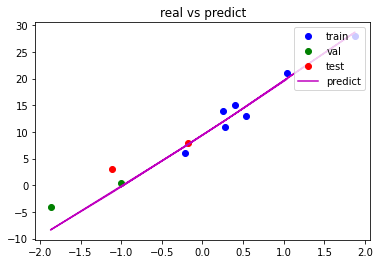

In [94]:
plt.title('real vs predict')
plt.plot(X_train_scaled[:, 1], y_train, 'bo', label='train')
plt.plot(X_val_scaled[:, 1], y_val, 'go', label='val')
plt.plot(X_test_scaled[:, 1], y_test, 'ro', label='test')
b = [ret_Theta[0] * x_squared + ret_Theta[1] * x + ret_Theta[2] for x_squared, x in X_scaled[:, 0:]]
plt.plot(a, b, c='m', label='predict')
plt.legend(loc='upper right')
plt.show()

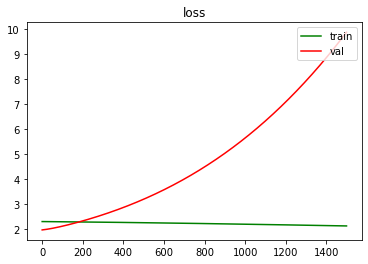

In [92]:
plt.title('loss')
plt.plot(train_predict, c='g', label='train')
plt.plot(val_predict, c='r', label='val')
plt.legend(loc='upper right')
plt.show()